In [55]:
import tensorflow as tf
import tensorflow.feature_column as fc 

import os
import sys
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

#tf.enable_eager_execution()
root_logdir = "./tf_logs"

# For output stability across multiple runs of the notebook
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print(sys.executable)

def shuffle_batch(X, batch_size):
    # Shuffle the indices
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    
    # Split the index array into the number of batches
    # Get the list of indexs per batch
    # and yield the values when asked
    for batch_idxs in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idxs]
        yield X_batch

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

tf.__version__

/Users/Work/anaconda3/envs/condaflow/bin/python


'1.13.1'

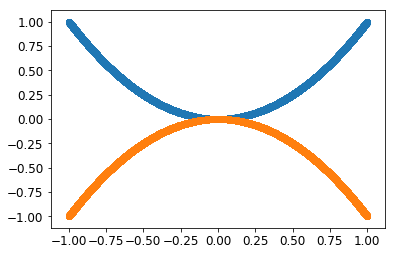

In [58]:
# Funcs to generate data
def y(x,sign=1):
    return x*x

# Data ranging from x = -0.5 to 0.5
def sample_data(n=10000, scale=100):
    data1 = []
    data2 = []
    
    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = y(x[i])
        y2i = -yi
        data1.append([x[i], yi])
        data2.append([x[i], y2i])
        
    return np.float32(np.array(data1)), np.float32(np.array(data2))

nSamples = 20000
X1, X2 = sample_data(n=nSamples,scale=2)
train_data = np.concatenate([X1,X2],axis=1)
plt.scatter(X1[:,0], X1[:,1])
# plt.show()
plt.scatter(X2[:,0], X2[:,1])

In [85]:
from model import RoboGAN

reset_graph()

sess = tf.Session()

nDimX = X1.shape[1]
nDimY = X2.shape[1]

GAN = RoboGAN()

# Generating forward GAN = G: X -> Y
X = tf.placeholder(tf.float32, shape=(None,nDimX), name = "X")
G = GAN.generator(name="G")
D_Y = GAN.discriminator(name="D_Y")

# Generating backward GAN = F: Y -> X
Y = tf.placeholder(tf.float32, shape=(None, nDimY), name="Y")
F = GAN.generator(name="F")
D_X = GAN.discriminator(name="D_X")


In [86]:
# Loss for
with tf.GradientTape() as G_tape,   \
     tf.GradientTape() as D_Y_tape, \
     tf.GradientTape() as F_tape,   \
     tf.GradientTape() as D_X_tape:
    
    # Generating forward samples X -> Y
    fake_Y = G(X)
    D_Gy_logits = D_Y(fake_Y)
    D_Y_logits = D_Y(Y)
    
    # Generating backward samples X <- Y
    fake_X = F(Y)
    D_Fx_logits = D_X(fake_X) # D_Fx = D_X ( F(Y) )
    D_X_logits = D_X(X)
    
    G_Fx = G(fake_X)
    F_Gy = F(fake_Y)
    
    cycle_loss = GAN.cycle_consistency_loss(G_Fx, F_Gy, X, Y)
    
    G_loss = GAN.generator_loss(D_Gy_logits, heuristic=False) + cycle_loss
    D_Y_loss = GAN.discriminator_loss(real_output= D_Y_logits, fake_output= D_Gy_logits)
    
    F_loss = GAN.generator_loss(D_Fx_logits, heuristic=False) + cycle_loss
    D_X_loss = GAN.discriminator_loss(real_output= D_X_logits, fake_output= D_Fx_logits)
    
    G_gradients = G_tape.gradient(G_loss, G.trainable_variables)
    D_Y_gradients = D_Y_tape.gradient(D_Y_loss, D_Y.trainable_variables)
    
    F_gradients = F_tape.gradient(F_loss, F.trainable_variables)
    D_X_gradients = D_X_tape.gradient(D_X_loss, D_X.trainable_variables)

## Setting up optimizers

In [87]:
opt_G = tf.train.AdamOptimizer(1e-3)
opt_D_Y = tf.train.AdamOptimizer(1e-3)
opt_F = tf.train.AdamOptimizer(1e-3)
opt_D_X = tf.train.AdamOptimizer(1e-3)

train_G = opt_G.apply_gradients(zip(G_gradients, G.trainable_variables))
train_F = opt_F.apply_gradients(zip(F_gradients, F.trainable_variables))

train_D_Y = opt_D_Y.apply_gradients(zip(D_Y_gradients, D_Y.trainable_variables))
train_D_X = opt_D_X.apply_gradients(zip(D_X_gradients, D_X.trainable_variables))

In [88]:
# Getting summaries

tf.summary.histogram('D_Y/true', D_Y_logits)
tf.summary.histogram('D_Y/fake', D_Gy_logits)
tf.summary.histogram('D_X/true', D_X_logits)
tf.summary.histogram('D_X/fake', D_Fx_logits)

tf.summary.scalar('loss/G', G_loss)
tf.summary.scalar('loss/D_Y', D_Y_loss)
tf.summary.scalar('loss/F', F_loss)
tf.summary.scalar('loss/D_X', D_X_loss)
tf.summary.scalar('loss/cycle', cycle_loss)

summary_op = tf.summary.merge_all()

## Running the training via a tensorflow session
> Generators will be trained first

In [96]:
sess =  tf.Session()
sess.run(tf.global_variables_initializer())

# Delete exisiting events file
for file in os.listdir(root_logdir):
    os.remove(root_logdir+"/"+file)

train_writer = tf.summary.FileWriter(root_logdir, tf.get_default_graph())

start_time = time.time()
batch_size = 100
n_batches = nSamples / batch_size

for epoch in range(30):
    for batch_index, batch in enumerate(shuffle_batch(train_data, batch_size)):
        X_batch = batch[:,:nDimX]
        Y_batch = batch[:,nDimX:]
        
        
        # Training Generators G and F first w/ cycle consistency
        Gloss, Floss, _,_ = sess.run([G_loss, F_loss, train_G, train_F],
                                     feed_dict={X:X_batch, Y:Y_batch})
        
        # Optimizing Discriminators D_X and D_Y
        D_Xloss, D_Yloss, _,_, summary = sess.run([D_X_loss, D_Y_loss, train_D_X, train_D_Y, summary_op],
                                         feed_dict={X: X_batch, Y: Y_batch})
        
        step = epoch * n_batches + batch_index 
        if step % 100 == 0:
            train_writer.add_summary(summary, step)
#         train_writer.flush()
    
    print("Epoch {}: GLoss:{:.4f}, FLoss:{:.4f}, DXLoss:{:.4f}, DYLoss:{:.4f}".format(epoch,Gloss,Floss,D_Xloss,D_Yloss))

print("Runtime: {:.3f}s".format(time.time()-start_time))
train_writer.close()

Epoch 0: GLoss:1.2437, FLoss:1.2552, DXLoss:0.6614, DYLoss:0.6785
Epoch 1: GLoss:0.9464, FLoss:1.0042, DXLoss:0.6886, DYLoss:0.6919
Epoch 2: GLoss:0.9412, FLoss:0.9652, DXLoss:0.6585, DYLoss:0.6824
Epoch 3: GLoss:0.8929, FLoss:0.9110, DXLoss:0.6697, DYLoss:0.6803
Epoch 4: GLoss:0.9004, FLoss:0.9155, DXLoss:0.6816, DYLoss:0.6853
Epoch 5: GLoss:0.8726, FLoss:0.8519, DXLoss:0.6878, DYLoss:0.6913
Epoch 6: GLoss:0.8217, FLoss:0.8460, DXLoss:0.6904, DYLoss:0.6911
Epoch 7: GLoss:0.8058, FLoss:0.8334, DXLoss:0.6878, DYLoss:0.6909
Epoch 8: GLoss:0.7763, FLoss:0.7753, DXLoss:0.6878, DYLoss:0.6900
Epoch 9: GLoss:0.7980, FLoss:0.7797, DXLoss:0.6874, DYLoss:0.6919
Epoch 10: GLoss:0.8112, FLoss:0.7779, DXLoss:0.6864, DYLoss:0.6919
Epoch 11: GLoss:0.7597, FLoss:0.7668, DXLoss:0.6875, DYLoss:0.6905
Epoch 12: GLoss:0.7833, FLoss:0.7866, DXLoss:0.6904, DYLoss:0.6915
Epoch 13: GLoss:0.7843, FLoss:0.7908, DXLoss:0.6831, DYLoss:0.6906
Epoch 14: GLoss:0.7539, FLoss:0.7834, DXLoss:0.6879, DYLoss:0.6915
Epoch

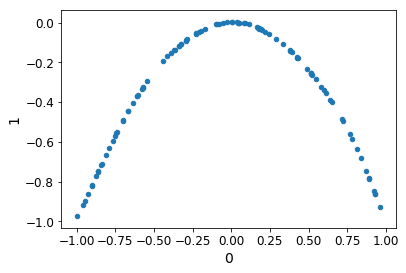

In [97]:


a=sess.run([fake_Y], feed_dict={X:X1[:100]})
temp=pd.DataFrame(a[0])
temp.plot.scatter(x=0, y=1)

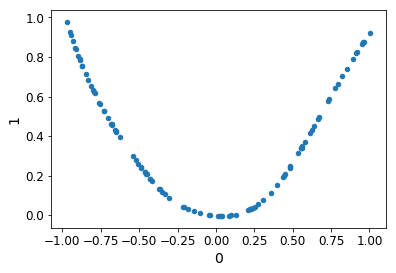

In [44]:
b=sess.run([fake_X], feed_dict={Y:X2[:100]})
temp2=pd.DataFrame(b[0])
temp2.plot.scatter(x=0, y=1)

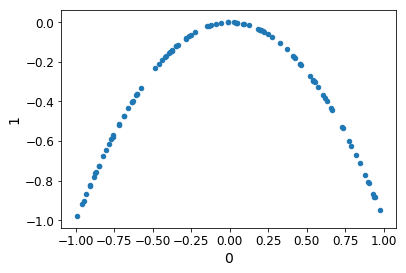

In [41]:
pd.DataFrame(X2[:100]).plot.scatter(x=0,y=1)

In [66]:
train_writer.get_logdir()

'./tf_logs'

In [79]:
tf.summary

<module 'tensorflow._api.v1.summary' from '/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/_api/v1/summary/__init__.py'>

In [92]:
n_batches

200.0